In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patheffects
import matplotlib as mpl
import numpy as np
import pandas as pd
import vice

from surp.analysis.apogee_analysis import subgiants
import seaborn as sns
from surp.analysis import plotting_utils as pluto

from surp._globals import AGB_MODELS
import arya

from surp import yields

using vice version  1.4.0.dev1


/home/daniel/surp/surp/analysis/apogee_analysis.py:135: DtypeWarning: Columns (126) have mixed types. Specify dtype option on import or set low_memory=False.
  subgiants = pd.read_csv(abs_path)


In [3]:
def plot_ssp(M_H_min = -2.5, M_H_max=0.5, **kwargs):
    Zs = 0.014*10**np.linspace(M_H_min, M_H_max, 100)
    mass_yields = []
    
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])

    plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6), **kwargs)
    
    plt.xlabel(r"$\log_{10} Z\,/\,Z_{\odot}$")
    plt.ylabel(r"$y_{\rm C}^{\rm AGB}$")

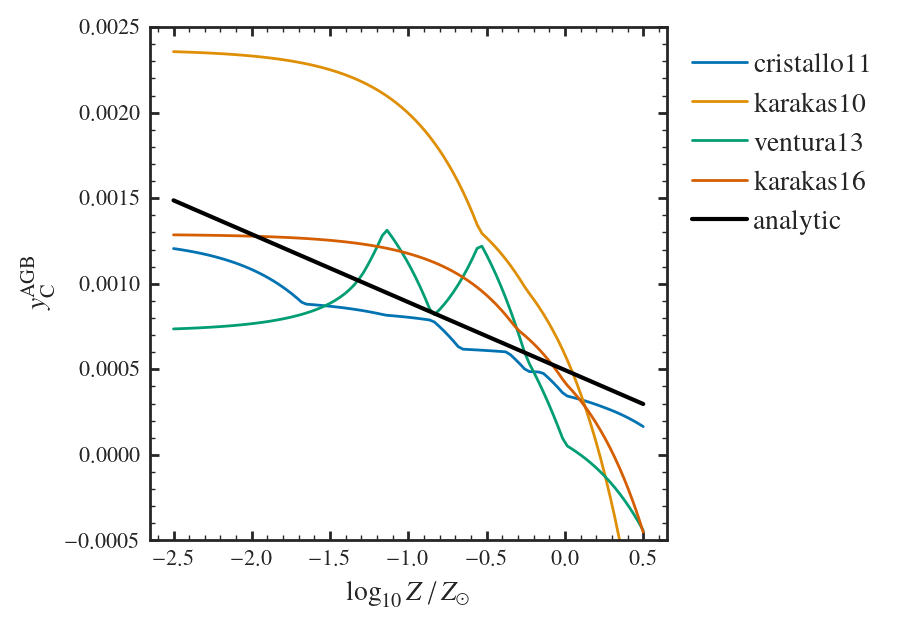

In [4]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0

for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model
    plot_ssp(label=model)


vice.yields.agb.settings["c"] = yields.a_agb()
plot_ssp(label="analytic", color="k", lw=1.5)
plt.ylim(-0.0005, 0.0025)

arya.Legend(loc=-1)

plt.savefig("agb_ana_vs_z.pdf")

In [4]:
def plot_dtd(ele="c", Z=0.014, **kwargs):
    m_c, times = vice.single_stellar_population(ele, Z=Z)
    m_c = np.array(m_c)
    y = m_c/m_c[-1]
    plt.plot(times, y, **kwargs)
    
    plt.xlabel(r"$t\,/\,{\rm Gyr}$")
    plt.ylabel(r"$M(t)\,/\,M_{\rm tot}$")

In [5]:
def plot_fe_dtd():
    vice.yields.ccsne.settings["fe"] = 0

    m_fe, times = vice.single_stellar_population("fe", Z=0.014)
    m_fe = [fe for fe in m_fe]
    plt.plot(times, np.array(m_fe)/m_fe[-1], label="SNe Ia Fe",
             linestyle="--", color="k")
    


In [39]:
def plot_c_fe(Z = 0.014, f_agb=0.2, f_ia=0.5, **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z, dt=0.005)
    m_fe, times = vice.single_stellar_population("fe", Z=Z, dt=0.005)

    discard = 50
    m_c = np.array(m_c)/m_c[-1]
    m_fe = np.array(m_fe)/m_fe[-1]
    f_c = m_c * f_agb + 1-f_agb
    f_fe = m_fe * f_ia + 1-f_ia
    x=np.log10(f_fe)
    y = np.log10(f_c)
    plt.plot(x, y, **kwargs)

    plt.xlim(0.1, -0.5)
    plt.ylim(-0.3, 0.1)
    plt.xlabel(r"$\log {\rm Fe}(t)$")
    plt.ylabel(r"$\log {\rm C}(t)$")

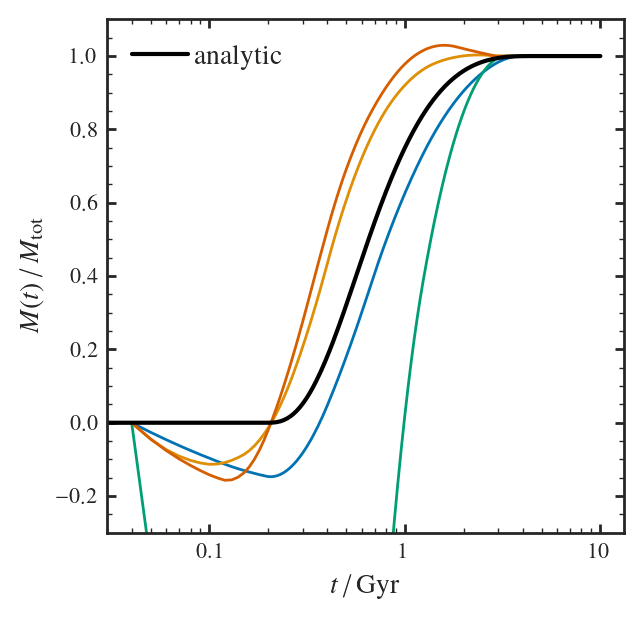

In [7]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0


for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model
    plot_dtd()

vice.yields.agb.settings["c"] = yields.a_agb()
plot_dtd(label="analytic", color="k", lw=1.5)

plt.xscale("log")
plt.legend()
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

plt.savefig("agb_ana_dtd.pdf")

In [6]:
yields.a_agb?

Signature:
yields.a_agb(
    m_low=1.3,
    m_mid=None,
    m_high=4,
    yl_agb=0,
    ym_agb=0.0005,
    yh_agb=0,
    mz_agb=-0.0004,
)
Docstring:
An analytic version of AGB yields.

Parameters
----------
m_low: the beginning of the cubic spline.
m_mid: the peak mass. If None, defaults to the average of m_low and m_high
m_high: the end of the cubic spline. 
yl_agb: the yield at m_low
ym_agb: the total yield
yh_agb: the yield at m_high 
mz_agb: the metallicity dependent part of the yield at ym_agb
File:      ~/surp/surp/yields.py
Type:      function

In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0


for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model
    plot_c_fe(label=model)

    
arya.Legend(color_only=True)



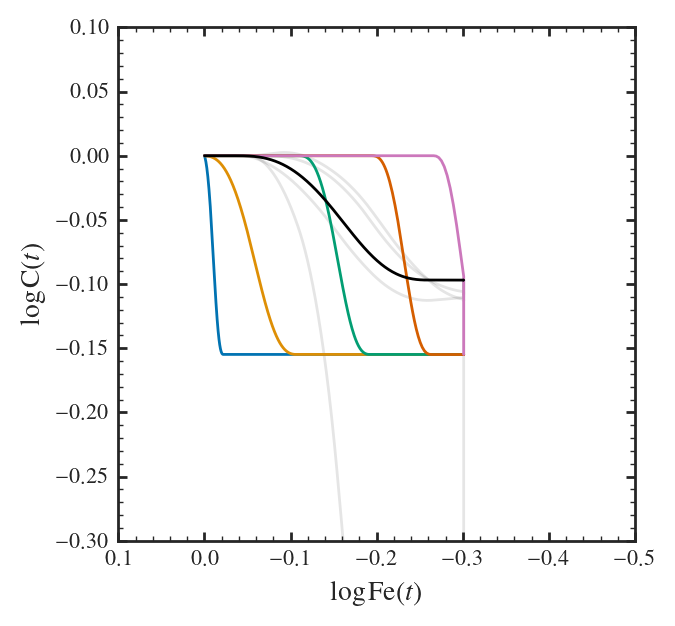

In [43]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0


for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model
    plot_c_fe(alpha=0.1, color="k")

for i in range(5):
    m_low = [1, 1, 2, 3, 4][i]
    m_high = [1.2, 2, 3, 4, 5][i]
    
    vice.yields.agb.settings["c"] = yields.a_agb(m_low=m_low, m_high=m_high, mz_agb=-7e-4)

    plot_c_fe(label=(m_low + m_high)/2, f_agb=0.3)
    
vice.yields.agb.settings["c"] = yields.a_agb()

plot_c_fe(label="fiducial", color="k")



In [8]:
def compare_to_studies(model):
    nrows = 4
    ncols = 2
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(7, 6), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0, wspace=0)

    c1 = arya.style.COLORS[0:4]
    c2 = "k"
    
    Zs = [0.0001, 0.0003, 0.001, 0.003, 0.006, 0.01, 0.014, 0.02]
    Ms = np.linspace(1, 8, 100)

    for i in range(nrows*ncols):
        Z = Zs[i]
        ax = axs[i // ncols][i % ncols]
        plt.sca(ax)

        for j in range(4):
            f_y = vice.yields.agb.interpolator("c", study=AGB_MODELS[j])
            y = [f_y(a, Z) for a in Ms]
            plt.plot(Ms, y, color=c1[j], alpha=0.3, ls="-", zorder=2)

        y = [model(a, Z) for a in Ms]
        plt.plot(Ms, y, color=c2, zorder=1)

        plt.text(0.6, 0.8, "$Z=%0.4f$" % Z, transform=ax.transAxes)


    fig.supylabel(r'$y_{\rm C}^{\rm AGB}$')
    fig.supxlabel(r'$M\,/\,M_{\odot}$')



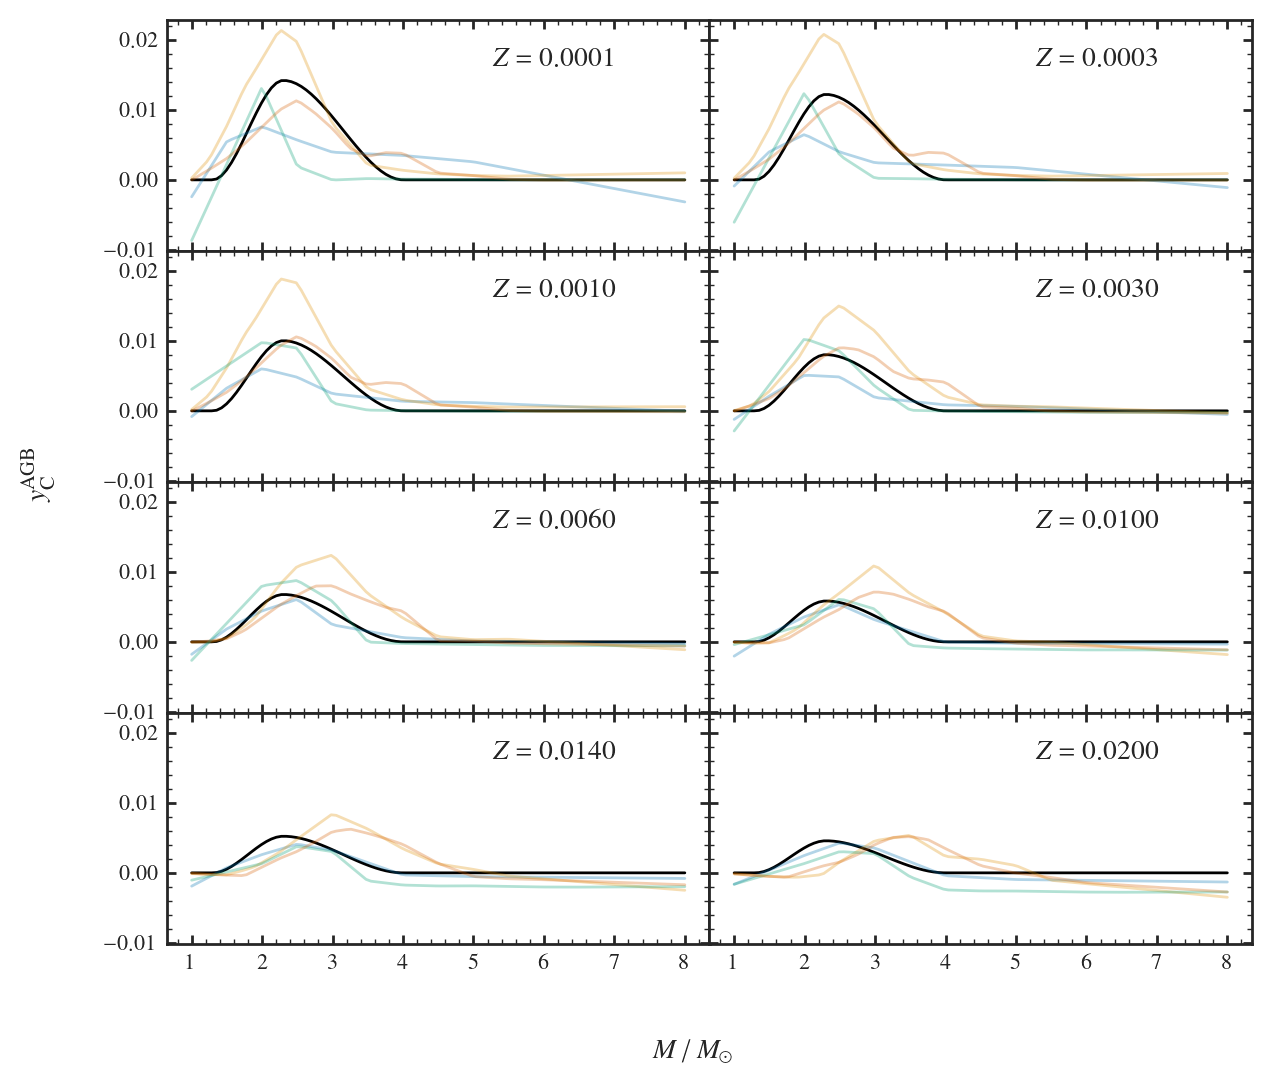

In [10]:
compare_to_studies( yields.a_agb(m_low=1.3, m_mid=2.3, m_high=4))

plt.savefig("analytic_vs_studies_agb.pdf")

(-0.6, 0.3)

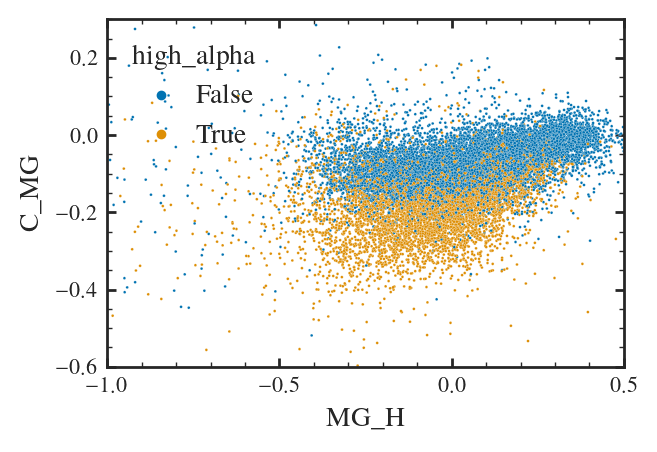

In [5]:
sns.scatterplot(subgiants, x="MG_H", y="C_MG", hue="high_alpha", s=1)
plt.xlim(-1, 0.5)
plt.ylim(-0.6, 0.3)